In [1]:
#Notebook taken from https://www.kaggle.com/kernels/scriptcontent/1741106/download

import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math
import gc


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../kkbox_data"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

members.csv
members.csv.7z
sample_submission.csv
sample_submission.csv.7z
song_extra_info.csv
song_extra_info.csv.7z
songs.csv
songs.csv.7z
submission_lgbm_avg.csv
submission_lgbm_avg.csv.gz
test.csv
test.csv.7z
train.csv
train.csv.7z



/Users/dur-rbaral-m/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
print('Loading data...')
data_path = '../kkbox_data/'
train = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv(data_path + 'test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')
print('Done loading...')

Loading data...
Done loading...


In [3]:
print('Data merging...')


train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

# import gc
# del members, songs; gc.collect();

print('Done merging...')

Data merging...
Done merging...


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 24 columns):
msno                  object
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
target                uint8
song_length           uint32
genre_ids             category
artist_name           category
composer              category
lyricist              category
language              category
city                  category
bd                    uint8
gender                category
registered_via        category
expiration_date       int64
membership_days       int64
registration_year     int64
registration_month    int64
registration_date     int64
expiration_year       int64
expiration_month      int64
song_year             float64
dtypes: category(12), float64(1), int64(7), object(1), uint32(1), uint8(2)
memory usage: 823.8+ MB


In [5]:
print ("Adding new features")

def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1

train.genre_ids = train.genre_ids.cat.add_categories("no_genre_id")
train['genre_ids'].fillna('no_genre_id',inplace=True)

test.genre_ids = test.genre_ids.cat.add_categories("no_genre_id")
test['genre_ids'].fillna('no_genre_id',inplace=True)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)
print("done adding genre id")

Adding new features
done adding genre id


In [6]:
print("adding lyricist count")
def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train.lyricist = train.lyricist.cat.add_categories("no_lyricist")
train['lyricist'].fillna('no_lyricist',inplace=True)
test.lyricist = test.lyricist.cat.add_categories("no_lyricist")
test['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)
print("done adding lyricist count")

adding lyricist count
done adding lyricist count


In [7]:
print("adding composer count")
def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train.composer = train.composer.cat.add_categories("no_composer")
train['composer'].fillna('no_composer',inplace=True)
test.composer = test.composer.cat.add_categories("no_composer")
test['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)
print("done adding composer count")

adding composer count
done adding composer count


In [8]:
print("adding featured count")
def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train.artist_name = train.artist_name.cat.add_categories("no_artist")
train['artist_name'].fillna('no_artist',inplace=True)
test.artist_name = test.artist_name.cat.add_categories("no_artist")
test['artist_name'].fillna('no_artist',inplace=True)
train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)
print("done adding feature count")

adding featured count
done adding feature count


In [9]:
#train['artist_name'] = train['artist_name'].astype(object)
#train['composer'] = train['composer'].astype(object)
#train['zpt'] = (train['artist_name'] == train['composer']).astype(np.int8)
#print(set((train['artist_name'] == train['composer']).astype(np.int8)))
#train['artist_name'] = train['artist_name'].astype('category')
#train['composer'] = train['composer'].astype('category')
#print(train["zpt"].shape, train.shape)

In [10]:
print("adding artist count")
def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

# if artist is same as composer, change type to object before comparing because two fields are of different categories
train['artist_name'] = train['artist_name'].astype(object)
train['composer'] = train['composer'].astype(object)
train['lyricist'] = train['lyricist'].astype(object)
test['artist_name'] = test['artist_name'].astype(object)
test['composer'] = test['composer'].astype(object)
test['lyricist'] = test['lyricist'].astype(object)
train['artist_composer'] = (train['artist_name'] == train['composer']).astype(np.int8)
test['artist_composer'] = (test['artist_name'] == test['composer']).astype(np.int8)


# if artist, lyricist and composer are all three same
train['artist_composer_lyricist'] = ((train['artist_name'] == train['composer']) & (train['artist_name'] == train['lyricist']) & (train['composer'] == train['lyricist'])).astype(np.int8)
test['artist_composer_lyricist'] = ((test['artist_name'] == test['composer']) & (test['artist_name'] == test['lyricist']) & (test['composer'] == test['lyricist'])).astype(np.int8)

#convert back to category after comparision
train['artist_name'] = train['artist_name'].astype('category')
train['composer'] = train['composer'].astype('category')
train['lyricist'] = train['lyricist'].astype('category')
test['artist_name'] = test['artist_name'].astype('category')
test['composer'] = test['composer'].astype('category')
test['lyricist'] = test['lyricist'].astype('category')
print("done adding artist count")

adding artist count
done adding artist count


In [11]:
# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0
train['language'] = train['language'].astype('object')
test['language'] = test['language'].astype('object')
train['language'] = train.language.fillna(0)
test['language'] = test.language.fillna(0)

train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)
train['language'] = train['language'].astype('category')
test['language'] = test['language'].astype('category')
print("done song lang")

done song lang


In [12]:
_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)
print("done smaller song")

done smaller song


In [13]:
# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
    

train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)
print("done count song played")

done count song played


In [14]:
# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)


print("Done adding features")

Done adding features


In [15]:
print ("Train test and validation sets")
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')


X_train = train.drop(['target'], axis=1)
y_train = train['target'].values


X_test = test.drop(['id'], axis=1)
ids = test['id'].values


# del train, test; gc.collect();

d_train_final = lgb.Dataset(X_train, y_train)
watchlist_final = lgb.Dataset(X_train, y_train)
print('Processed data...')

Train test and validation sets
Processed data...


In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 34 columns):
msno                        category
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
song_length                 uint32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    category
city                        category
bd                          uint8
gender                      category
registered_via              category
expiration_date             int64
membership_days             int64
registration_year           int64
registration_month          int64
registration_date           int64
expiration_year             int64
expiration_month            int64
song_year                   float64
genre_ids_count             int8
lyricists_count             in

In [16]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 10,#200 is original value
        'metric' : 'auc'
    }

%time model_f1 = lgb.train(params, train_set=d_train_final,  valid_sets=watchlist_final, verbose_eval=5)

/Users/dur-rbaral-m/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/dur-rbaral-m/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[5]	valid_0's auc: 0.731363
[10]	valid_0's auc: 0.743262
CPU times: user 3min 41s, sys: 21.3 s, total: 4min 2s
Wall time: 31.4 s


In [17]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'dart',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 10, #200,
        'metric' : 'auc'
    }

%time model_f2 = lgb.train(params, train_set=d_train_final,  valid_sets=watchlist_final, verbose_eval=5)

[5]	valid_0's auc: 0.731363
[10]	valid_0's auc: 0.742303
CPU times: user 2min 34s, sys: 1.82 s, total: 2min 36s
Wall time: 14.2 s


In [68]:
X_test.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,224130,458,梁文音 (Rachel Liang),Qi Zheng Zhang,no_lyricist,...,0,1,0,0,0,0,0,1,694,13654
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,320470,465,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,...,2,1,0,0,0,0,0,0,6090,115325
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,315899,2022,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,...,1,1,0,0,0,0,1,0,5,989
3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,285210,465,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,no_lyricist,...,0,4,0,0,0,0,0,0,31,698
4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,197590,873,Yoga Mr Sound,Neuromancer,no_lyricist,...,0,1,0,0,0,0,0,1,5,180


In [69]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 34 columns):
msno                        category
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
song_length                 uint32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    category
city                        category
bd                          uint8
gender                      category
registered_via              category
expiration_date             int64
membership_days             int64
registration_year           int64
registration_month          int64
registration_date           int64
expiration_year             int64
expiration_month            int64
song_year                   float64
genre_ids_count             int8
lyricists_count             in

In [70]:
print('Making predictions')
p_test_1 = model_f1.predict(X_test)
p_test_2 = model_f2.predict(X_test)
p_test_avg = np.mean([p_test_1, p_test_2], axis = 0)
print('Done making predictions')

Making predictions
Done making predictions


In [19]:
print ('Saving predictions Model model of gbdt')

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test_avg
subm.to_csv(data_path + 'submission_lgbm_avg.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Saving predictions Model model of gbdt
Done!


# Random Forest and XGBoost

In [20]:
from sklearn import metrics, ensemble
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [21]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'expiration_date', 'membership_days',
       'registration_year', 'registration_month', 'registration_date',
       'expiration_year', 'expiration_month', 'song_year', 'genre_ids_count',
       'lyricists_count', 'composer_count', 'is_featured', 'artist_count',
       'artist_composer', 'artist_composer_lyricist', 'song_lang_boolean',
       'smaller_song', 'count_song_played', 'count_artist_played'],
      dtype='object')

In [22]:
test.columns

Index(['id', 'msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language', 'city', 'bd', 'gender', 'registered_via',
       'expiration_date', 'membership_days', 'registration_year',
       'registration_month', 'registration_date', 'expiration_year',
       'expiration_month', 'song_year', 'genre_ids_count', 'lyricists_count',
       'composer_count', 'is_featured', 'artist_count', 'artist_composer',
       'artist_composer_lyricist', 'song_lang_boolean', 'smaller_song',
       'count_song_played', 'count_artist_played'],
      dtype='object')

In [23]:
#train.registration_init_time = pd.to_datetime(train.registration_init_time, format='%Y%m%d', errors='ignore')
#train['registration_init_time_year'] = train['registration_init_time'].dt.year
#train['registration_init_time_month'] = train['registration_init_time'].dt.month
#train['registration_init_time_day'] = train['registration_init_time'].dt.day

# expiration_date
#train.expiration_date = pd.to_datetime(train.expiration_date,  format='%Y%m%d', errors='ignore')
#train['expiration_date_year'] = train['expiration_date'].dt.year
#train['expiration_date_month'] = train['expiration_date'].dt.month
#train['expiration_date_day'] = train['expiration_date'].dt.day
# Dates to categoty
#train['registration_init_time'] = train['registration_init_time'].astype('category')
#train['expiration_date'] = train['expiration_date'].astype('category')
# Object data to category
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].astype('category')
    
# Encoding categorical features
for col in train.select_dtypes(include=['category']).columns:
    train[col] = train[col].cat.codes

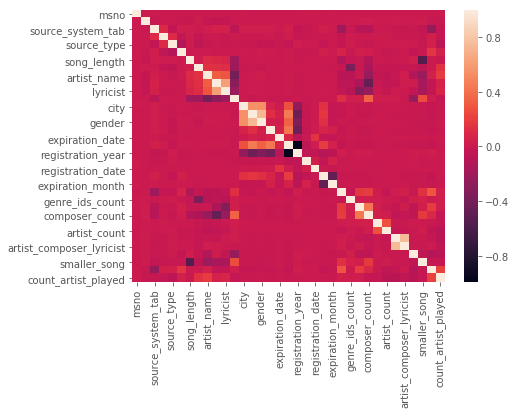

In [24]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(train.corr())
plt.show()

In [25]:
train.isnull().sum()

msno                             0
song_id                          0
source_system_tab                0
source_screen_name               0
source_type                      0
target                           0
song_length                      0
genre_ids                        0
artist_name                      0
composer                         0
lyricist                         0
language                         0
city                             0
bd                               0
gender                           0
registered_via                   0
expiration_date                  0
membership_days                  0
registration_year                0
registration_month               0
registration_date                0
expiration_year                  0
expiration_month                 0
song_year                   577858
genre_ids_count                  0
lyricists_count                  0
composer_count                   0
is_featured                      0
artist_count        

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 35 columns):
msno                        int16
song_id                     int32
source_system_tab           int8
source_screen_name          int8
source_type                 int8
target                      uint8
song_length                 uint32
genre_ids                   int16
artist_name                 int32
composer                    int32
lyricist                    int32
language                    int8
city                        int8
bd                          uint8
gender                      int8
registered_via              int8
expiration_date             int64
membership_days             int64
registration_year           int64
registration_month          int64
registration_date           int64
expiration_year             int64
expiration_month            int64
song_year                   float64
genre_ids_count             int8
lyricists_count             int8
composer_

In [27]:
# Replace NA
#for i in train.select_dtypes(include=['object']).columns:
#    train[i][train[i].isnull()] = 'unknown'
train['song_year'] = train['song_year'].fillna(value=0)

In [29]:
#Drop columns
#train = train.drop(['expiration_date', 'lyricist'], 1)

In [30]:
print(int(train.shape[0]/10))

737741


In [31]:
train = train[:int(train.shape[0]/10)]#reduce rows to observe faster

In [63]:
# use random forest to find best informative features
model_rf = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model_rf.fit(train[train.columns[train.columns != 'target']], train.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
train_plot = pd.DataFrame({'features': train.columns[train.columns != 'target'],'importances': model.feature_importances_})
train_plot = train_plot.sort_values('importances', ascending=False)

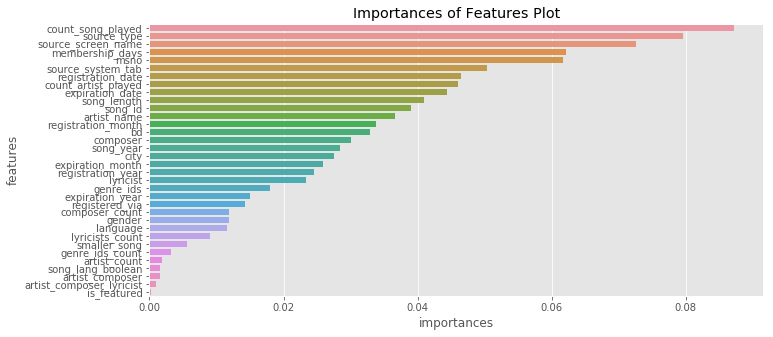

In [40]:
plt.figure(figsize=[11,5])
sns.barplot(x = train_plot.importances, y = train_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [76]:
#convert test data into categorical code because sklearn won't understand non numeric data
for col in test.select_dtypes(include=['object']).columns:
    test[col] = test[col].astype('category')
    
# Encoding categorical features
for col in test.select_dtypes(include=['category']).columns:
    test[col] = test[col].cat.codes

In [78]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,0,12934,122191,3,7,3,224130,281,24890,33218,...,0,1,0,0,0,0,0,1,694,13654
1,1,12934,217907,3,7,3,320470,286,24743,47678,...,2,1,0,0,0,0,0,0,6090,115325
2,2,712,37385,0,-1,9,315899,151,21878,43194,...,1,1,0,0,0,0,1,0,5,989
3,3,1383,224360,5,12,7,285210,286,20718,39607,...,0,4,0,0,0,0,0,0,31,698
4,4,1383,85597,5,12,7,197590,402,21761,30731,...,0,1,0,0,0,0,0,1,5,180


In [81]:
ids = test.pop('id')

In [84]:
test['song_year'] = test['song_year'].fillna(0)

In [85]:
# Predicting
predict_labels_rf = model_rf.predict(test)

In [86]:
print ('Saving predictions Model model of Random Forest')

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = predict_labels_rf
subm.to_csv(data_path + 'submission_rf.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Saving predictions Model model of Random Forest
Done!


In [59]:
# Create model
model_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model_xgb.fit(train[train.columns[train.columns != 'target']], train.target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [87]:
# Predicting
predict_labels_xgb = model_xgb.predict(test)

In [88]:
print ('Saving predictions Model model of XGBoost')

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = predict_labels_xgb
subm.to_csv(data_path + 'submission_xgb.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Saving predictions Model model of XGBoost
Done!


In [89]:
#lets aggregate random forest and xgb
pred_xgb_rf = np.mean([predict_labels_xgb, predict_labels_rf], axis=0)
print ('Saving predictions from XGBoost and Rforest')

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = pred_xgb_rf
subm.to_csv(data_path + 'submission_rf_xgb.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Saving predictions from XGBoost and Rforest
Done!


In [90]:
#average lgb, rf, and xgb
pred_xgb_rf_lgb = np.mean([predict_labels_xgb, predict_labels_rf, p_test_avg], axis=0)
print ('Saving predictions from LGBM, XGBoost and Rforest')

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = pred_xgb_rf_lgb
subm.to_csv(data_path + 'submission_rf_xgb_lgb.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Saving predictions from LGBM, XGBoost and Rforest
Done!


In [124]:
np.array(train)[:10]

array([[ 8.15800e+03,  7.46790e+04,  1.00000e+00,  6.00000e+00,
         5.00000e+00,  2.06471e+05,  2.39000e+02,  3.27700e+03,
         1.45810e+04,  2.28880e+04,  9.00000e+00,  0.00000e+00,
         0.00000e+00, -1.00000e+00,  4.00000e+00,  5.00000e+00,
         2.10300e+03,  2.01200e+03,  1.00000e+00,  2.00000e+00,
         2.01700e+03,  1.00000e+01,  2.01600e+03,  1.00000e+00,
         0.00000e+00,  2.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00,
         2.15000e+02,  1.14000e+03],
       [ 1.72590e+04,  2.23479e+05,  3.00000e+00,  7.00000e+00,
         4.00000e+00,  2.84584e+05,  6.80000e+01,  3.19600e+04,
         6.48810e+04,  2.28880e+04,  9.00000e+00,  4.00000e+00,
         2.40000e+01,  0.00000e+00,  5.00000e+00,  1.10000e+01,
         2.30100e+03,  2.01100e+03,  5.00000e+00,  2.50000e+01,
         2.01700e+03,  9.00000e+00,  1.99900e+03,  1.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
   

In [120]:
#check if we can get better result with best estimators
#The best estimator was selected by Randomized Grid Search with Stratified Shuffle Split Cross Validation.
# Create model

model_param = xgb.XGBClassifier()

# Create parameters grid

parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

# Strategy of cross validation

cv = model_selection.StratifiedShuffleSplit(train_labels, test_size = 0.3, random_state=0)

# Create Grid search Strategy

grid_cv = model_selection.RandomizedSearchCV(model_param, parameters_grid, scoring = 'accuracy', cv = cv)

# Fit model by Grid
print(X_train.shape, y_train.shape)
grid_cv.fit(np.array(train), np.array(target))

# Model with the best estimator

grid_cv.bestestimator

(7377418, 34) (7377418,)


TypeError: 'Series' object cannot be interpreted as an integer

In [102]:
print("COMPLETED!")

COMPLETED!


In [103]:
# Randomized Search for Algorithm Tuning
import numpy as np
from scipy.stats import uniform as sp_rand
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
# load the diabetes datasets
dataset = datasets.load_diabetes()
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(dataset.data, dataset.target)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a56549748>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)
0.4891440737480681
0.05000505968578439


In [105]:
type(dataset)

sklearn.utils.Bunch

In [108]:
type(dataset.target)

numpy.ndarray

In [109]:
dataset.target.shape

(442,)

In [110]:
dataset.data.shape

(442, 10)